<a href="https://colab.research.google.com/github/nrlarini03/Deep-Learning-CNN/blob/main/Project_G211220008_G211220047_G211220052.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#metode mobilenetv2 urut

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
dataset_path = "/content/drive/MyDrive/Semester 7/Pengolahan Citra/Praktikum/daun"

print(os.listdir(dataset_path))


['kelas 2', 'kelas 1', 'kelas 3']


In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)


Found 24 images belonging to 3 classes.
Found 5 images belonging to 3 classes.


In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3385 - loss: 1.3210 - val_accuracy: 0.4000 - val_loss: 0.9900
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step - accuracy: 0.5312 - loss: 0.9011 - val_accuracy: 0.6000 - val_loss: 1.0738
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step - accuracy: 0.7812 - loss: 0.7689 - val_accuracy: 0.4000 - val_loss: 1.0257
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7500 - loss: 0.5903 - val_accuracy: 0.4000 - val_loss: 0.9941
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 817ms/step - accuracy: 0.8542 - loss: 0.4440 - val_accuracy: 0.4000 - val_loss: 1.0000
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 867ms/step - accuracy: 0.8750 - loss: 0.3438 - val_accuracy: 0.4000 - val_loss: 1.0172
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 781ms/step - accuracy: 0.8646 - loss: 0.3110 - val_accuracy: 0.4000 - val_loss: 1.0126
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9323 - loss: 0.2692 - val_accuracy: 0.4000 - val_loss: 1.0038


In [ ]:
feature_extractor = Model(
    inputs=model.input,
    outputs=model.layers[-2].output
)


In [ ]:
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg','.png','.jpeg')):
            image_paths.append(os.path.join(root, file))

print("Total images:", len(image_paths))


Total images: 30


In [ ]:
def extract_feature(img_path):
    img = load_img(img_path, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feat = feature_extractor.predict(img, verbose=0)
    return feat.flatten()

features = np.array([extract_feature(p) for p in image_paths])
print("Feature shape:", features.shape)


Feature shape: (30, 1280)


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(features)


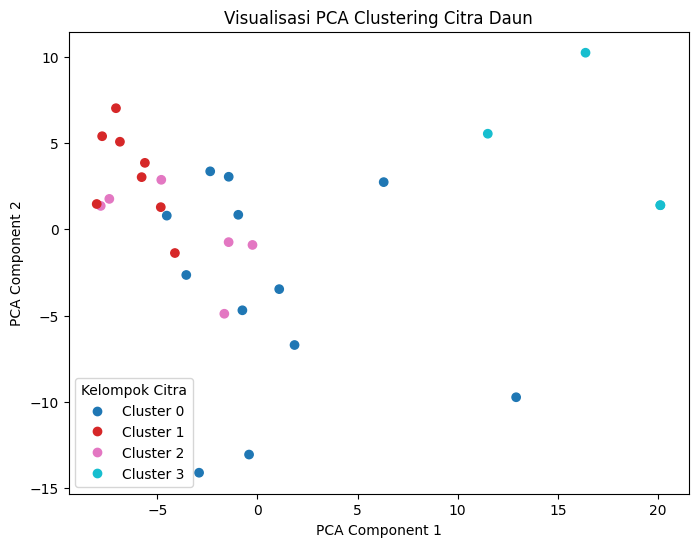

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    pca_result[:,0],
    pca_result[:,1],
    c=labels,
    cmap='tab10'
)

# Membuat legend manual berdasarkan cluster
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in range(len(handles))]

plt.legend(handles, legend_labels, title="Kelompok Citra")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualisasi PCA Clustering Citra Daun")

plt.show()


Cluster 0


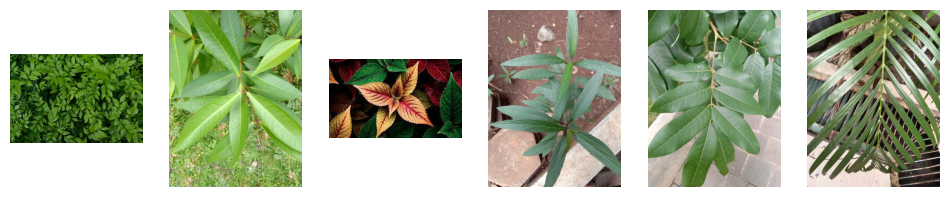

Cluster 1


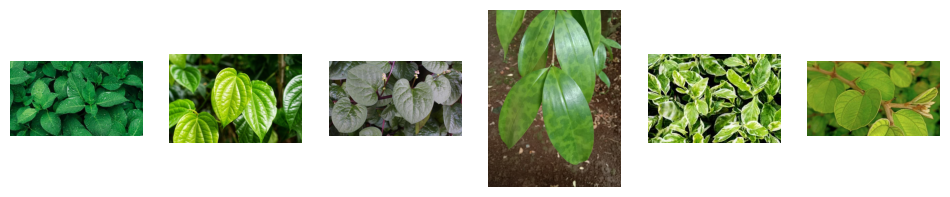

Cluster 2


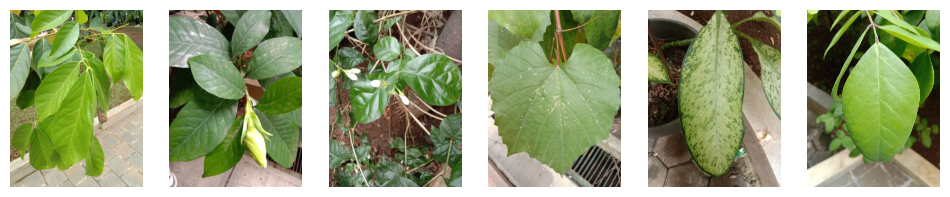

Cluster 3


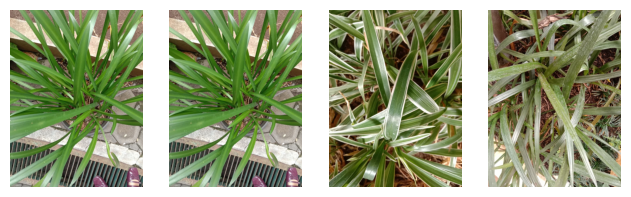

In [ ]:
for c in range(4):
    print(f"Cluster {c}")
    idxs = np.where(labels == c)[0][:6]
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(idxs):
        plt.subplot(1,6,i+1)
        plt.imshow(mpimg.imread(image_paths[idx]))
        plt.axis('off')
    plt.show()


In [ ]:
def find_similar(query_path, top_k=3):
    q_feat = extract_feature(query_path).reshape(1,-1)
    sims = cosine_similarity(q_feat, features)[0]
    idx = np.argsort(sims)[-top_k:][::-1]
    return idx, sims[idx]


In [ ]:
from google.colab import files
uploaded = files.upload()
query_img = list(uploaded.keys())[0]

idx, scores = find_similar(query_img)


Saving daun.jpg to daun (2).jpg


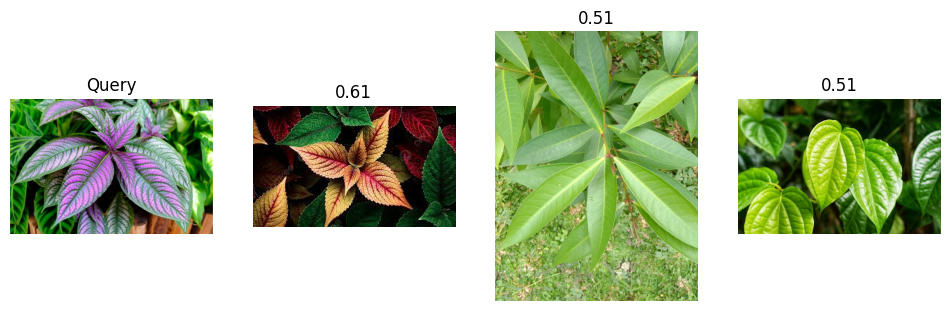

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, len(idx)+1, 1)
plt.imshow(load_img(query_img))
plt.title("Query")
plt.axis('off')

for i, j in enumerate(idx):
    plt.subplot(1, len(idx)+1, i+2)
    plt.imshow(load_img(image_paths[j]))
    plt.title(f"{scores[i]:.2f}")
    plt.axis('off')
plt.show()
